In [1]:
%matplotlib inline
%load_ext lab_black

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as msno
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import math
from shared import solar_altitude, daylength

resources = "resources/"
data_path = os.path.join(resources, "data.csv.gz")
tv_split_path = os.path.join(resources, "tv_split.csv.gz")
test_split_path = os.path.join(resources, "test_split.csv.gz")

# Exploratory data analysis

## First glance at the data

Let us load the selected data:

In [2]:
# Loading the selected data
df = pd.read_csv(data_path)
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
# We add time derived features
df["month"] = df["TIMESTAMP"].dt.month
df["year"] = df["TIMESTAMP"].dt.year
df["day_of_year"] = df["TIMESTAMP"].dt.dayofyear
# We set the sitename and date as indexes
df.set_index(["sitename", "TIMESTAMP"], drop=False, inplace=True)
df.index.names = ["site", "date"]

if df.index.duplicated().sum() > 0:
    raise Error("Duplicated index!")

print(f"Number of sites: {len(df.index.get_level_values(0).unique())}")
print(f"Sample count: {len(df)}")

Number of sites: 58
Sample count: 221353


Let us load the sites metadata and add some extra features such as the mean annual temperature and precipitation and the sampling duration:

In [3]:
# Loading the sites info
site_df = pd.read_csv(
    os.path.join(resources, "fdk_site_info.csv"), index_col="sitename"
)

# We compute the mean annual temperature (MAT) and mean annual precipitation (MAP)
# which are simply indicators helping us to characterize the climate at each site.

# Mean annual temperature
TA_MA = (
    df[["sitename", "TA_F_MDS", "year"]]
    .groupby(["sitename", "year"])
    .mean()
    .groupby(level=["sitename"])
    .mean()
    .squeeze()
)
site_df["MAT"] = TA_MA

# Mean annual precipitation
P_MA = (
    df[["sitename", "P_F", "year"]]
    .groupby(["sitename", "year"])
    .sum()
    .groupby(level=["sitename"])
    .mean()
    .squeeze()
)
site_df["MAP"] = P_MA

# We drop sites without the quantity calculated above (meaning that this site is not present in the time series)
site_df = site_df[~site_df["MAP"].isna()]

# We add the series duration (in years)
site_df["duration"] = site_df["year_end"] - site_df["year_start"] + 1

In [ ]:
# Convert into a GeoDataFrame
sites_gdf = gpd.GeoDataFrame(
    site_df,
    geometry=gpd.points_from_xy(site_df["lon"], site_df["lat"]),
    crs="EPSG:4326",
)

# Wold map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the data points on the map
fig, ax = plt.subplots(nrows=1, figsize=(10, 8))
world.plot(color="white", edgecolor="black", ax=ax)
sites_gdf.plot("duration", s=30, legend=True, ax=ax)
ax.set_title(
    "Geographical repartition of the selected sites (sample duration color-coded)"
)
plt.tight_layout()
plt.show()

We can see that the selected sites are mostly located in North America and Europe.

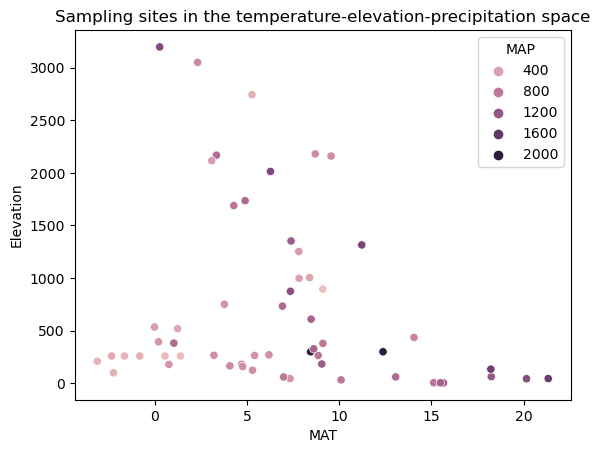

In [5]:
# We remove one site containing bad data to get a cleaner graph
d = site_df[~(site_df["MAT"] < -80)].copy()
sns.scatterplot(x="MAT", y="elv", hue="MAP", hue_norm=(0, 2000), data=d)
plt.ylabel("Elevation")
plt.title("Sampling sites in the temperature-elevation-precipitation space")
plt.show()

We can also see that our selection contains sites with very different average temperature and precipitation conditions.

## Data preparation

Before risking contaminating the data, let us do some minimal processing to get the data in shape before splitting it into a train/validate set and a test set.

### Data enrichment

Let us add first some site-specific data:

In [6]:
df_join = df.join(site_df[["lat"]], on="sitename")
df["lat"] = df_join["lat"]

We also compute the target variable as previously defined:

In [7]:
df["GPP"] = df[["GPP_NT_VUT_REF", "GPP_DT_VUT_REF"]].mean(axis=1, skipna=False)
df["GPP_diff"] = df["GPP_NT_VUT_REF"] - df["GPP_DT_VUT_REF"]

### Null values location

Let us visualize the location of missing values:

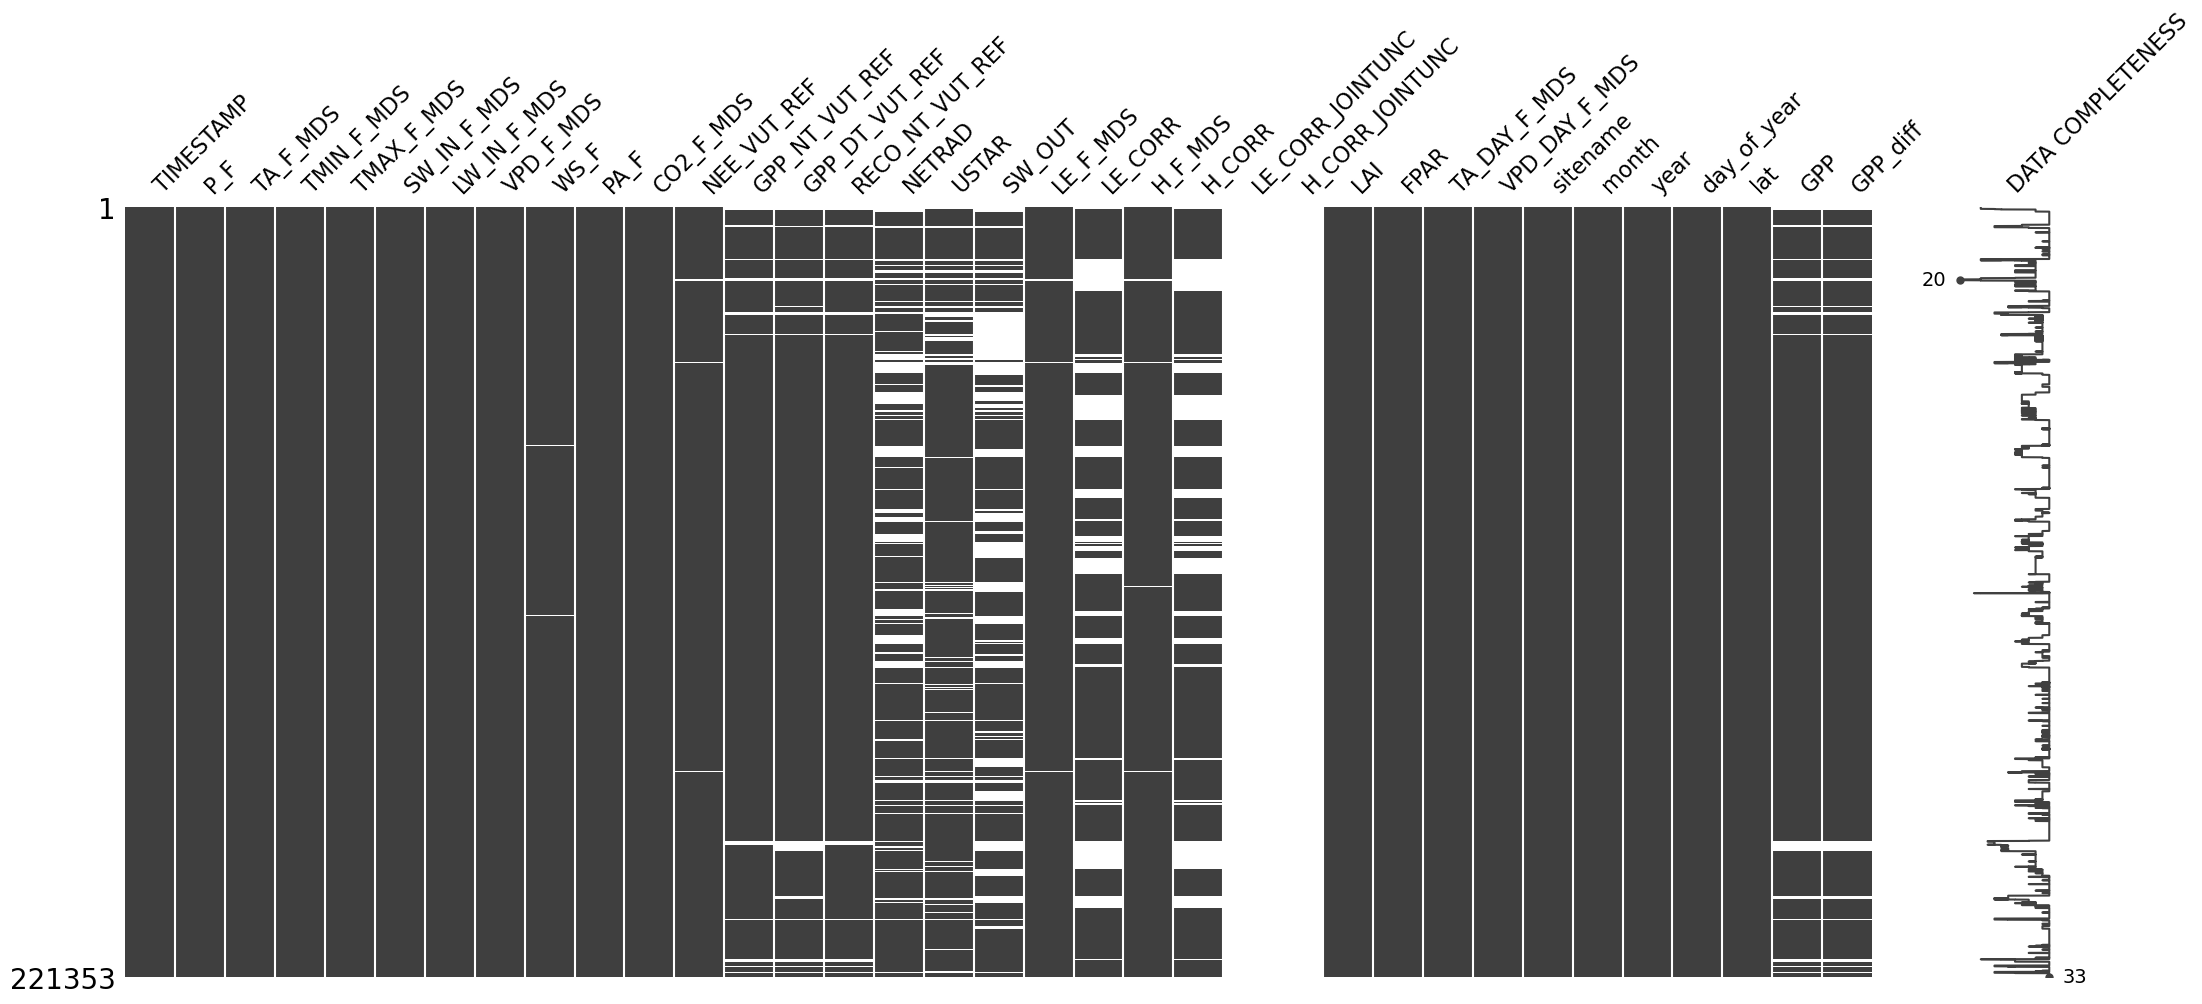

In [8]:
# We get the list of features which do not end with '_QC' (quality flags)
def features(data):
    return [f for f in data.columns.values if not f.endswith("_QC")]


msno.matrix(df[features(df)], labels=True)
plt.show()

Features containing `_CORR`, `NETRAD`, and `SW_OUT` are features which can be used for energy balance computations, and are therefore not directly useful for our purpose. Since they contain many missing values, we discard them. `USTAR` undergoes the same fate as it is already implicitly used by other features. And so does `"NEE_VUT_REF` and `RECO_NT_VUT_REF` as they are also included in GPP estimates.

Furthermore, `TMIM_F_MDS` and `TMAX_F_MDS` are always equal to `TA_F_MDS`. We discard them too.

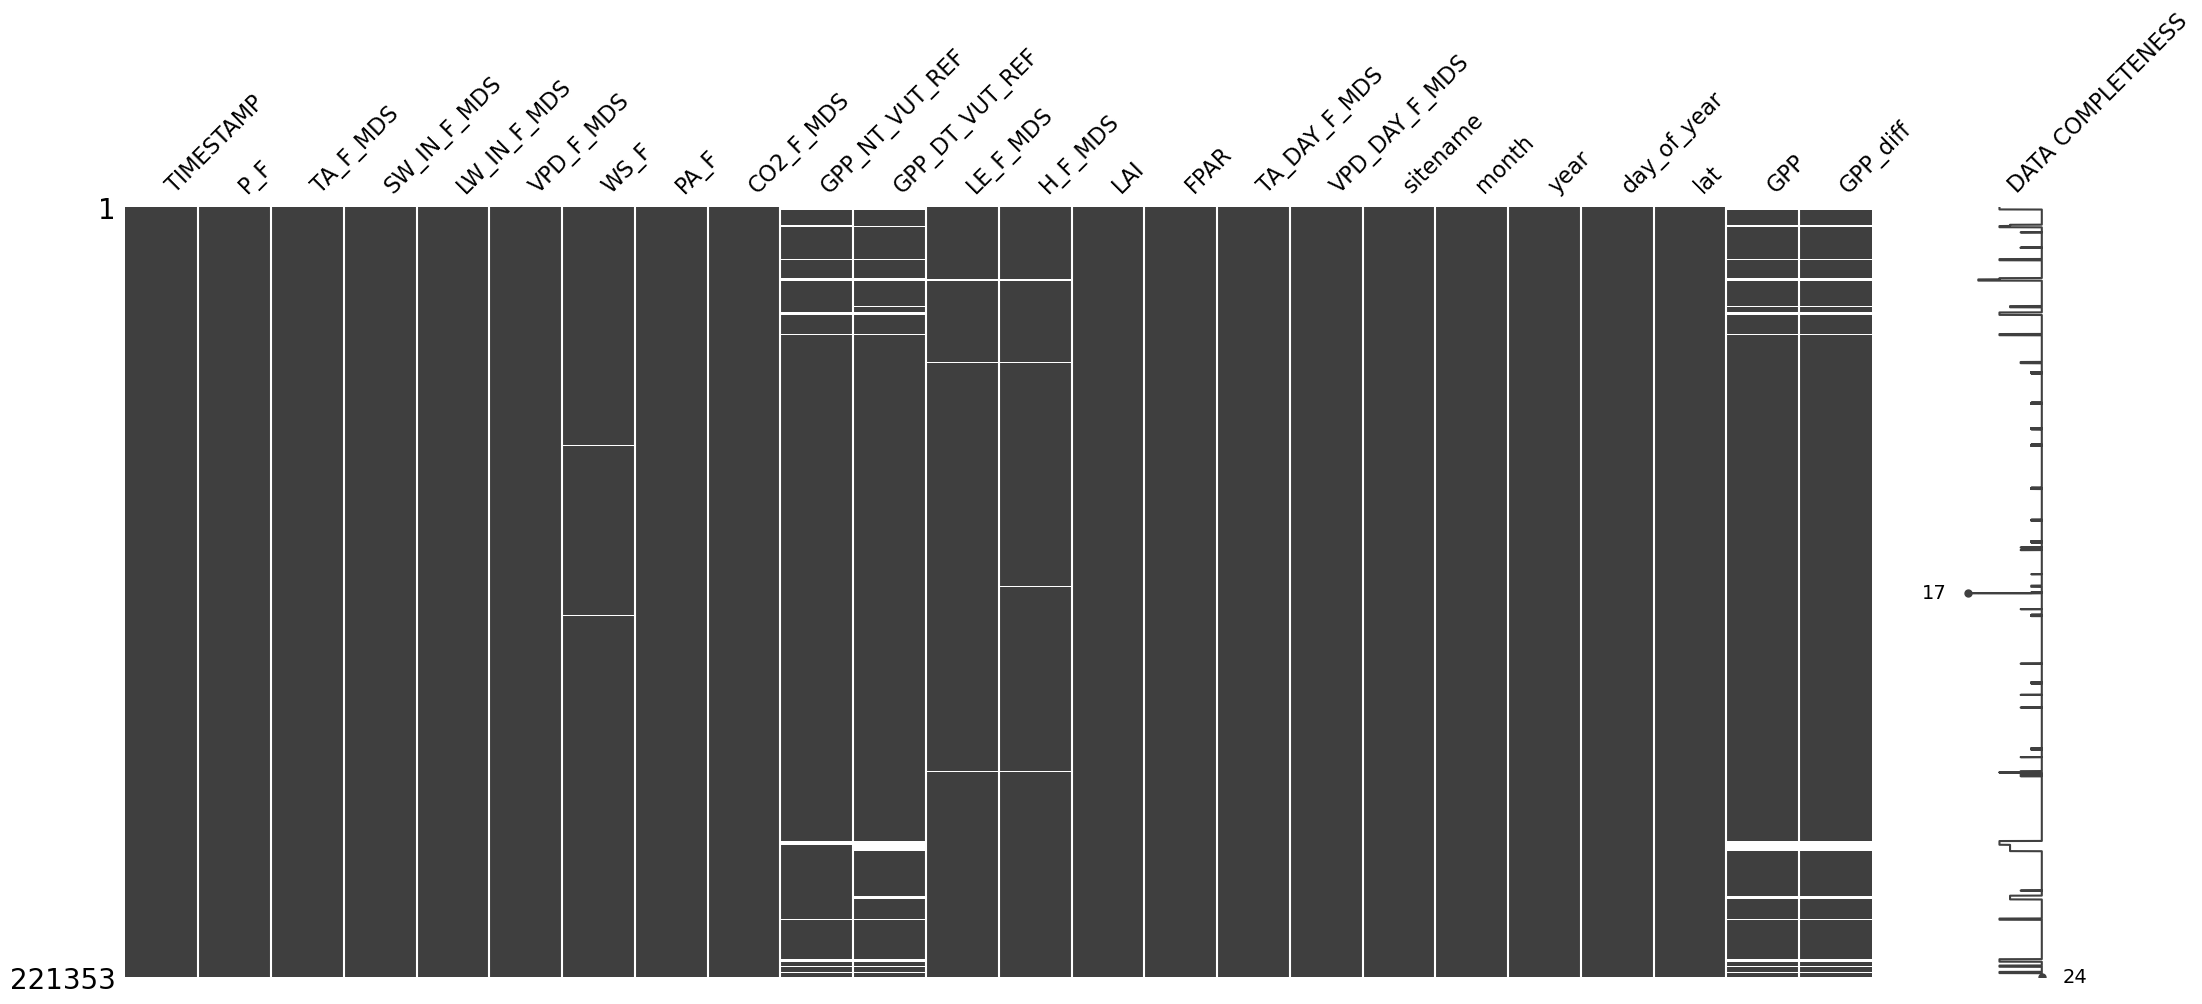

In [9]:
discarded_features = [
    "NETRAD",
    "SW_OUT",
    "USTAR",
    "NEE_VUT_REF",
    "RECO_NT_VUT_REF",
    "H_CORR",
    "LE_CORR",
    "H_CORR_JOINTUNC",
    "LE_CORR_JOINTUNC",
    "NETRAD_QC",
    "USTAR_QC",
    "H_CORR_QC",
    "LE_CORR_QC",
    "TMIN_F_MDS",
    "TMAX_F_MDS",
]
df.drop(discarded_features, inplace=True, axis=1)
msno.matrix(df[features(df)], labels=True)
plt.show()

### Bad data

#### Quality flags

The original dataset contains hourly data, which has been downsampled to daily data.
The [dataset documentation](https://fluxnet.org/data/fluxnet2015-dataset/variables-quick-start-guide/) explains that quality control flags, denoted by the suffix `_QC`, (cf features marked with an asterisk '\*' in the table above).
According to the dataset documentation, this indicator corresponds to the proportion of measured, or good quality gap-filled, data backing the downsampled value.

Let us look for example at the distribution of `TA_F_MDS_QC`, which is the quality flag for `TA_F_MDS` (air temperature):

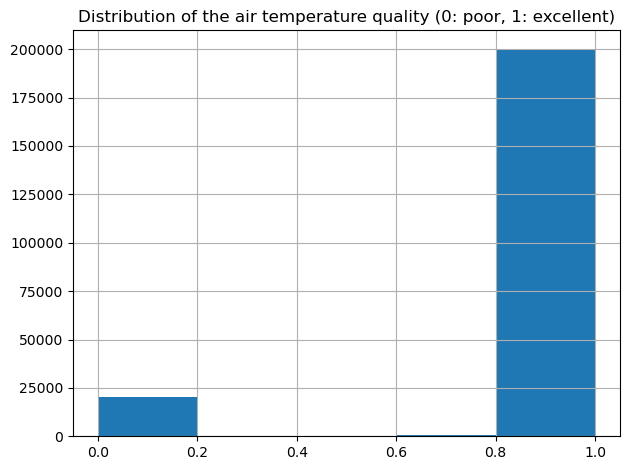

In [10]:
df["TA_F_MDS_QC"].hist(bins=5)
plt.title("Distribution of the air temperature quality (0: poor, 1: excellent)")
plt.tight_layout()
plt.show()

Let us observe the air temperature at a site where the quality flag falls to 0:

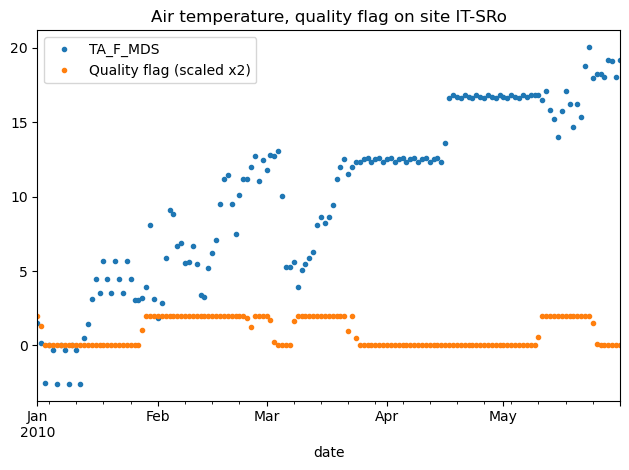

In [11]:
d = df.loc["IT-SRo"]
d["TA_F_MDS"]["2010-01":"2010-05"].plot(style=".")
(2 * d["TA_F_MDS_QC"])["2010-01":"2010-05"].plot(
    style=".", label="Quality flag (scaled x2)"
)
plt.legend()
plt.title("Air temperature, quality flag on site IT-SRo")
plt.tight_layout()
plt.show()

As can be shown on the plot below, when the quality flag is zero, it looks like the dataset architects have decided to use some kind of fill forward strategy.

Note: regarding `CO2_F_MDS`, the quality flag is almost always 0 because yearly world average values are used:

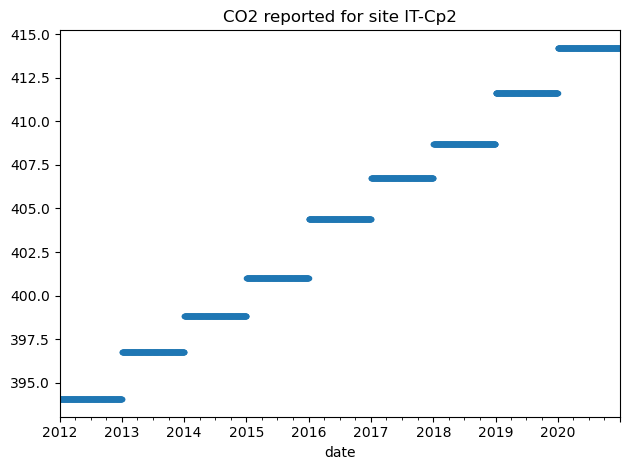

In [12]:
d = df.loc["IT-Cp2"]
d["CO2_F_MDS"].plot(style=".")
plt.title("CO2 reported for site IT-Cp2")
plt.tight_layout()
plt.show()

Because we are interested in the effect of local environmental variables only, we discard this feature.

Let us visualize how much data is of very low quality:

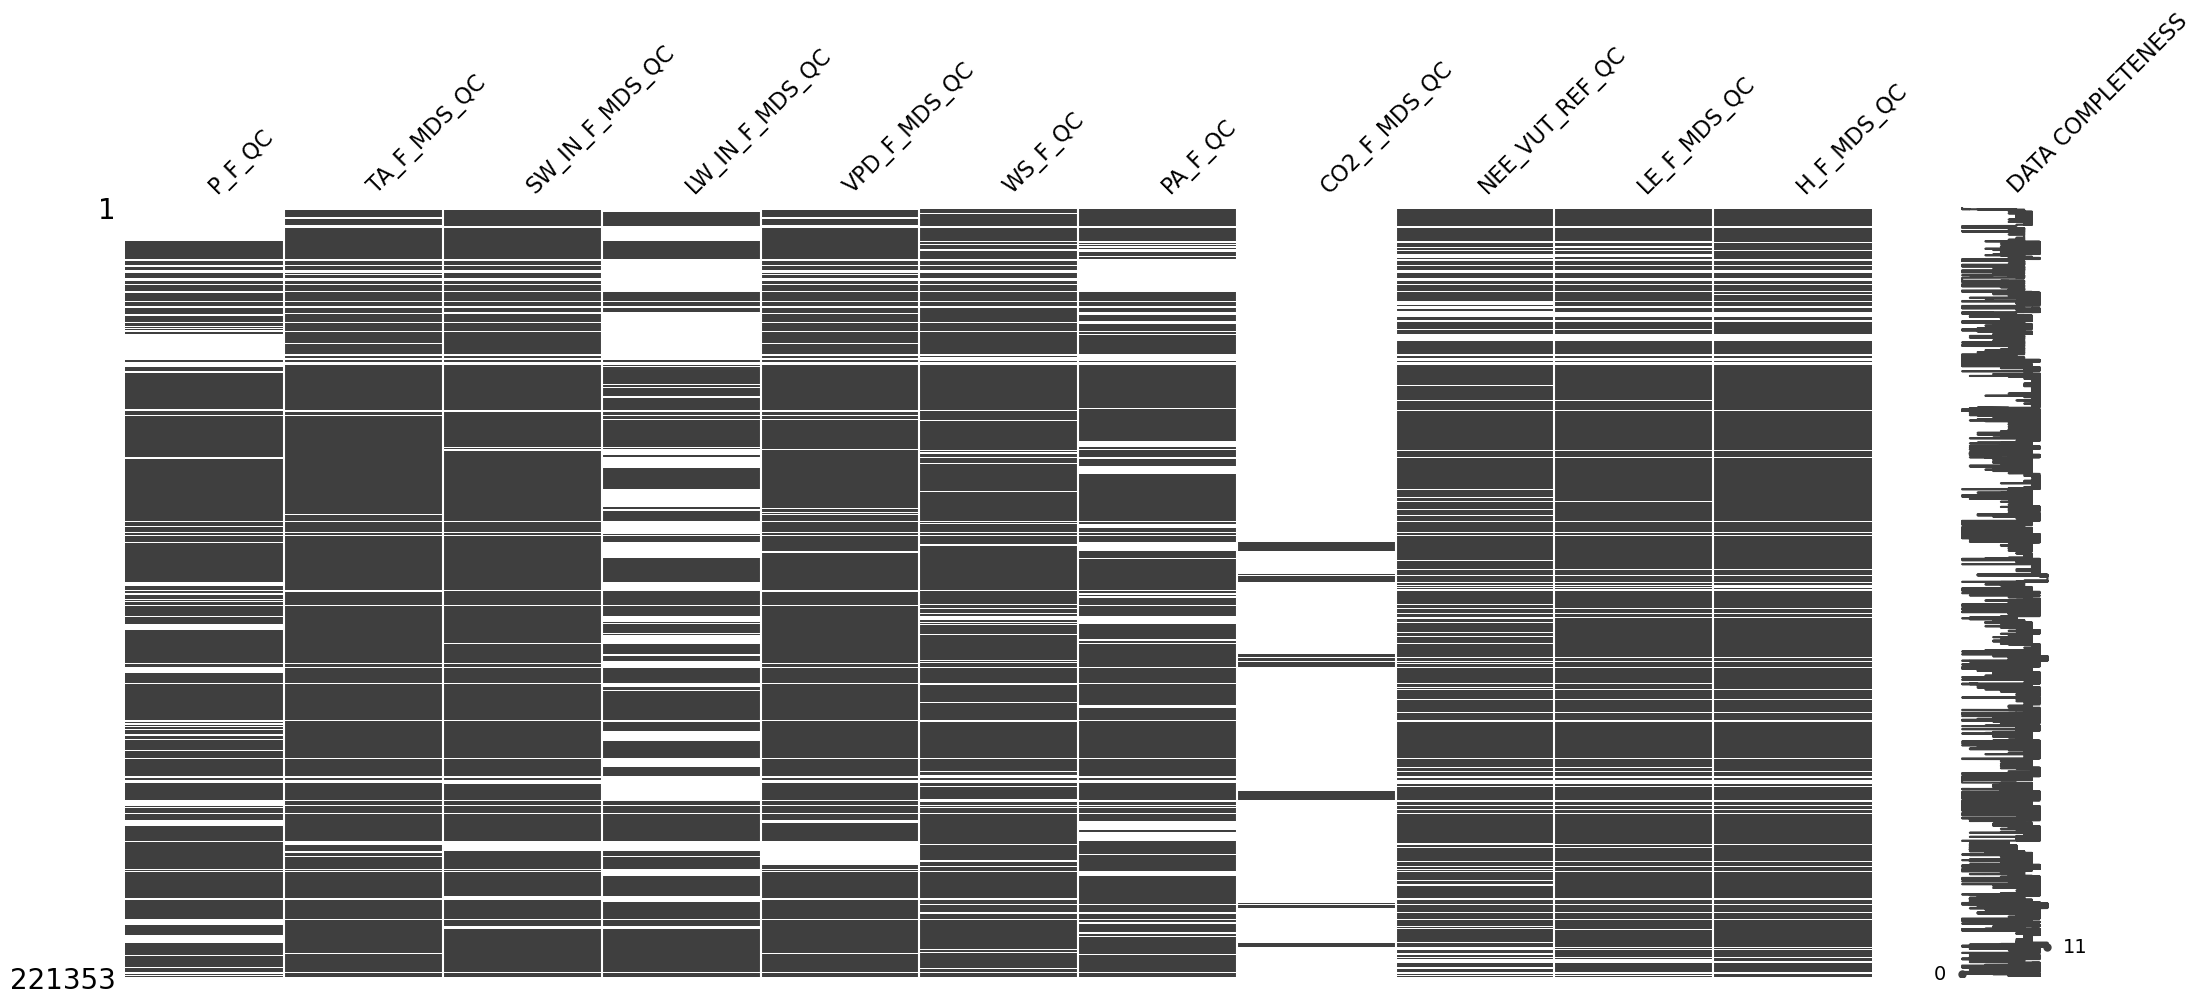

In [13]:
qc_threshold = 0.5
f_qc = [f for f in df.columns.values if f.endswith("_QC")]
df_qc = df[f_qc].copy()
for f in f_qc:
    df_qc[f] = (df_qc[f] < qc_threshold).replace(True, np.nan)
msno.matrix(df_qc, labels=True)
plt.show()

Since we have enough data, we can be a bit aggressive and decide to discard any sample which has a low quality score in one of `TA_F_MDS_QC`, `SW_IN_F_MDS_QC`, `VPD_F_MDS_QC`, and `NEE_VUT_REF_QC` as those features are highly correlated with GPP:

In [14]:
f_qc_check = ["TA_F_MDS_QC", "SW_IN_F_MDS_QC", "VPD_F_MDS_QC", "NEE_VUT_REF_QC"]
bad_data_mask = (df[f_qc_check] < qc_threshold).any(axis=1)

Because the dataset is already forward filled, a few days of bad quality data is usually not a huge issue, while it is if the data is corrupted over periods of many weeks.
In the snippet below, we apply a filter on the mask we computed above, where we ignore any bad quality period that is smaller than 2 weeks:

In [15]:
def blur(x):
    d = x.loc[x.index[0][0]]
    return d.rolling(window="29d", center=True, min_periods=14).apply(
        lambda w: w.sum() > len(w) / 2
    )


smooth_bad_data_mask = bad_data_mask.groupby("site").apply(lambda x: blur(x)) == 1
trash_count = smooth_bad_data_mask.sum()

print(
    f"Samples to discard: {trash_count} ({(smooth_bad_data_mask.sum() / len(df)).round(2) * 100}%)"
)

Samples to discard: 48787 (22.0%)


This strategy leads us to discard a fifth of the dataset, but it is better to work with high data quality to get the best possible model ("Garbage in, garbage out").
We go ahead and remove the bad quality data:

In [16]:
df_clean = df[features(df)].copy()[~smooth_bad_data_mask]
len(df_clean)

172566

#### Obviously wrong values

In [17]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
P_F,172566.0,2.337581,6.123555,0.000000,0.000000,0.010000,1.706000,269.378999
TA_F_MDS,172566.0,7.247983,9.770537,-42.789480,0.827272,7.868208,14.368307,36.426040
SW_IN_F_MDS,172566.0,147.930349,101.804287,0.000000,58.176411,135.874960,228.452266,469.253401
LW_IN_F_MDS,172566.0,298.125109,50.441420,107.361375,265.507585,302.102917,332.825000,467.346874
VPD_F_MDS,172566.0,3.920519,3.982380,0.000000,0.916479,2.708094,5.610516,43.629396
WS_F,171729.0,2.391854,1.386673,0.000000,1.440521,2.104667,2.996062,18.203125
PA_F,172566.0,69.231843,478.535694,-9999.000000,85.911786,97.000000,99.310042,105.035417
CO2_F_MDS,172566.0,392.965010,14.583486,286.998168,382.089996,391.850006,404.410004,607.963188
GPP_NT_VUT_REF,172417.0,3.810131,3.619837,-14.672565,0.612097,3.074574,6.277021,25.448279
GPP_DT_VUT_REF,172424.0,3.617008,3.404005,0.000000,0.572402,2.769890,5.822165,25.311930


We can see that `PA_F` (atmospheric pressure) minimum value is `-9999`. The dataset documentation tells us that it may be used as a placeholder for missing value.
Because of rounding errors, we use `-9998` as a threshold:

In [18]:
# Replace values lower than a limit with NA:
def nullate_lower_than(d, field, limit=-9998):
    d.loc[d[field] <= limit, field] = np.nan


# The dataset documentation tells us that some features may use `-9999` as a placeholder for missing value.
for f in df_clean.select_dtypes(include="number").columns:
    nullate_lower_than(df_clean, f)

In [19]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
P_F,172566.0,2.337581,6.123555,0.000000,0.000000,0.010000,1.706000,269.378999
TA_F_MDS,172566.0,7.247983,9.770537,-42.789480,0.827272,7.868208,14.368307,36.426040
SW_IN_F_MDS,172566.0,147.930349,101.804287,0.000000,58.176411,135.874960,228.452266,469.253401
LW_IN_F_MDS,172566.0,298.125109,50.441420,107.361375,265.507585,302.102917,332.825000,467.346874
VPD_F_MDS,172566.0,3.920519,3.982380,0.000000,0.916479,2.708094,5.610516,43.629396
WS_F,171729.0,2.391854,1.386673,0.000000,1.440521,2.104667,2.996062,18.203125
PA_F,172182.0,91.685997,54.110945,-6423.391250,85.978599,97.015531,99.314042,105.035417
CO2_F_MDS,172566.0,392.965010,14.583486,286.998168,382.089996,391.850006,404.410004,607.963188
GPP_NT_VUT_REF,172417.0,3.810131,3.619837,-14.672565,0.612097,3.074574,6.277021,25.448279
GPP_DT_VUT_REF,172424.0,3.617008,3.404005,0.000000,0.572402,2.769890,5.822165,25.311930


`PA_F` still contains negative values. We set them to NA.

In [20]:
nullate_lower_than(df_clean, "PA_F", 0)

The order of magnitude of the min and max of other features look reasonable.

**Notes:**
- Although `GPP` is in theory a positive value, `GPP_NT_VUT_REF` may output negative values.
- Although one might expect the leaf index area (`LAI`) to be bounded by 1, it is not the case in a forest canopy where multiple layers of leaves may overlap.

#### GPP error

Let us have a look at `GPP_diff` (the difference between the two GPP models) to see if we can identify patterns indicating bad data:

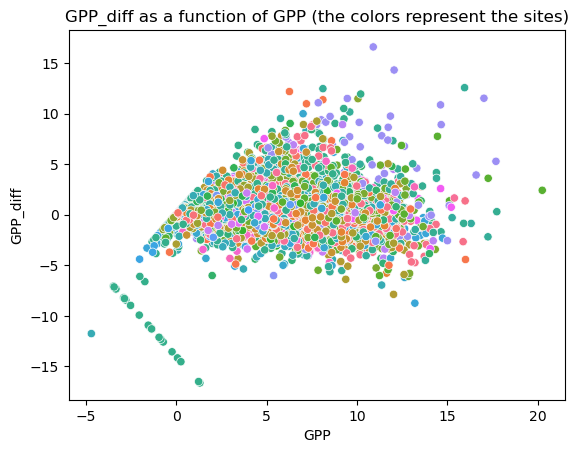

In [21]:
d = df_clean.sample(10000, random_state=0)
sns.scatterplot(x="GPP", y="GPP_diff", data=d, hue="sitename", legend=False)
plt.title("GPP_diff as a function of GPP (the colors represent the sites)")
plt.show()

There is a weird-looking line at the bottom-left corner belonging to the site `CH-Dav` where $\text{GPP_diff} < -5$.
We discard these values:

(172150, 24)


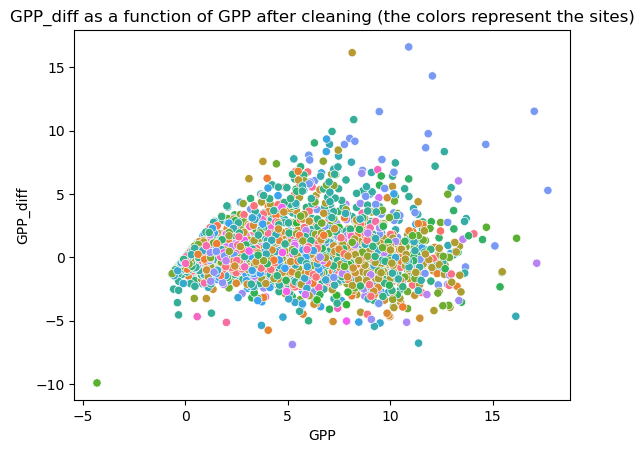

In [22]:
df_clean = df_clean[
    ~((df_clean["sitename"] == "CH-Dav") & (df_clean["GPP_diff"] < -5))
].copy()
print(df_clean.shape)
sns.scatterplot(
    x="GPP",
    y="GPP_diff",
    data=df_clean.sample(5000, random_state=0),
    hue="sitename",
    legend=False,
)
plt.title(
    "GPP_diff as a function of GPP after cleaning (the colors represent the sites)"
)
plt.show()

We verify that the distribution of GPP_diff is still unbiased:

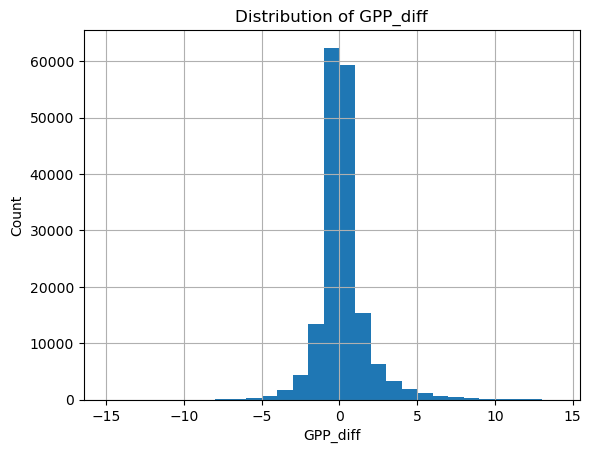

In [23]:
df_clean["GPP_diff"].hist(bins=range(-15, 15))
plt.xlabel("GPP_diff")
plt.ylabel("Count")
plt.title("Distribution of GPP_diff")
plt.show()

Let us see if some sites are contributing much to the GPP error:

In [24]:
display(
    np.abs(df_clean["GPP_diff"])
    .groupby("site")
    .describe()
    .sort_values("mean", ascending=False)
    .head(5)
)
display(
    np.abs(df_clean["GPP_diff"])
    .groupby("site")
    .describe()
    .sort_values("mean", ascending=False)
    .tail(5)
)

,count,mean,std,min,25%,50%,75%,max
site,,,,,,,,
CA-Ca1,3471.0,1.939477,2.429458,0.000319,0.382082,0.971499,2.549268,20.152350
DE-RuW,2216.0,1.878964,1.946397,0.000327,0.547199,1.255847,2.545416,20.292844
CH-Dav,8291.0,1.823648,1.831925,0.000117,0.549216,1.236413,2.515651,18.136630
IT-SR2,2762.0,1.584316,1.661084,0.000024,0.469040,1.054497,2.089739,12.933966
US-xTA,1077.0,1.538094,1.421842,0.001840,0.469349,1.100660,2.188289,9.696386


,count,mean,std,min,25%,50%,75%,max
site,,,,,,,,
FI-Sod,2429.0,0.396401,0.570152,0.000050,0.085303,0.214459,0.435136,5.487110
CA-Qfo,2572.0,0.379446,0.485255,0.000285,0.091872,0.212143,0.463716,5.321021
US-Me1,281.0,0.355959,0.294402,0.004386,0.143924,0.286630,0.476595,1.449915
CA-NS3,1035.0,0.354464,0.524117,0.000095,0.076086,0.176503,0.415983,4.678673
FI-Sii,1744.0,0.201674,0.311339,0.000098,0.033456,0.085624,0.234127,2.883960


We can see that the sites having the highest mean GPP diff also have a 3rd quartile that very low compared to the maximum value, indicating that even for those *noisy* sites, samples with high `GPP_diff` are rather marginal and not systematic.

### Local average features

The poor data quality forces us to discard a lot of samples, leaving us with fragmented time series with which it would not be convenient to work with.
Because we suspect that GPP is not only dependent on the present conditions, but also the past ones, especially regarding water availability, we add some rolling window averaging features which will preserve some kind of historicity in the data even after we remove the time component by shuffling the dataset.

We create two rolling windows of one and four weeks respectively for the precipitation, temperature and vapor pressure deficit:

In [25]:
def func(x, window):
    d = x.loc[x.index[0][0]]
    return d.rolling(window=f"{window}d", min_periods=int(window / 2)).apply(
        lambda w: w.mean()
    )


for f in ["P_F", "TA_F_MDS", "VPD_F_MDS"]:
    for period in [1, 4]:
        print(f"Processing {f}_{period}w...")
        df_clean[f"{f}_{period}w"] = df_clean.groupby("site").apply(
            lambda x: func(x[f], period * 7)
        )

Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...


In [26]:
(~df_clean.isna().any(axis=1)).sum()

165328

### Missing value handling

Let us look at their location again after the dataset cleaning we have already done.

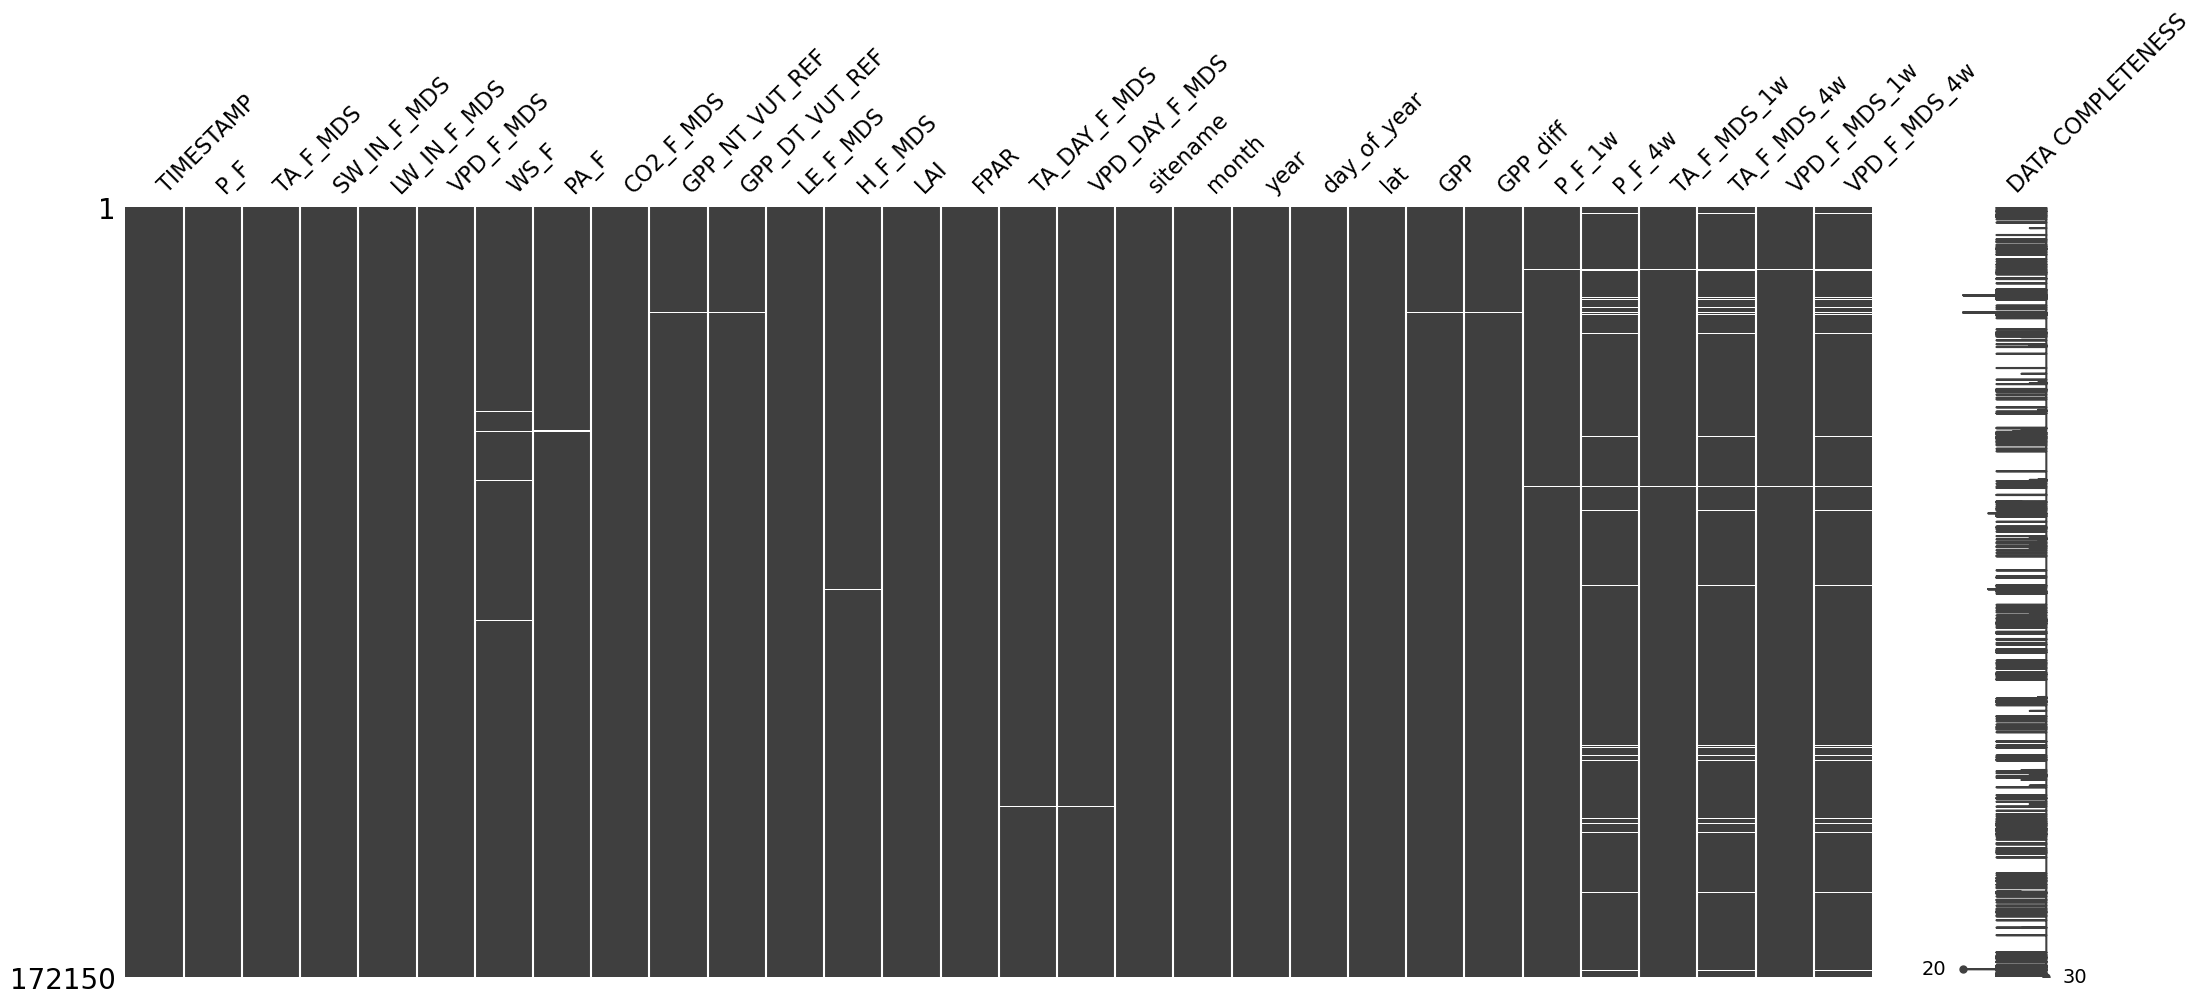

In [27]:
msno.matrix(df_clean[features(df_clean)], labels=True)
plt.show()

There are not many null vaules. The simplest is to discard them:

In [28]:
df_clean.dropna(inplace=True)
print(df_clean.shape)
print(
    f"The total cleaning process discarded {int((1 - len(df_clean) / len(df)) * 100)}% of the data."
)

(165328, 30)
The total cleaning process discarded 25% of the data.


This scheme leaves us with a large amount of data to work with.

## Features

### Additional features

Let us add some engineered features:
- `solar_alt`: Solar altitude angle (in degree)
- `day_length`: Length of the day (in hours)

The last two features can be derived from the day of the year and the latitude using simple trigonometry.
Below is an implementation based on [this work](https://gist.github.com/anttilipp/ed3ab35258c7636d87de6499475301ce):

In [29]:
df_clean["day_length"] = df_clean.apply(
    lambda x: daylength(x["day_of_year"], x["lat"]), axis=1
)
df_clean["solar_altitude"] = df_clean.apply(
    lambda x: solar_altitude(x["day_of_year"], x["lat"]), axis=1
)

Ideally, the water capacity content, precipitation, and other water and heat fluxes variables could be used as input to a soil-water balance model, but this is out of scope in this work.

Intuitively, it would make sense to use the product of `FPAR` (fraction of photosynthetically active radiation) and `SW_IN_F_MDS` (the shortwave incoming radiation), which should give an approximation of the absorbed energy used for photosynthesis (i.e. GPP).
We add this feature as `apar` (absorbed photosynthetic active radiation):

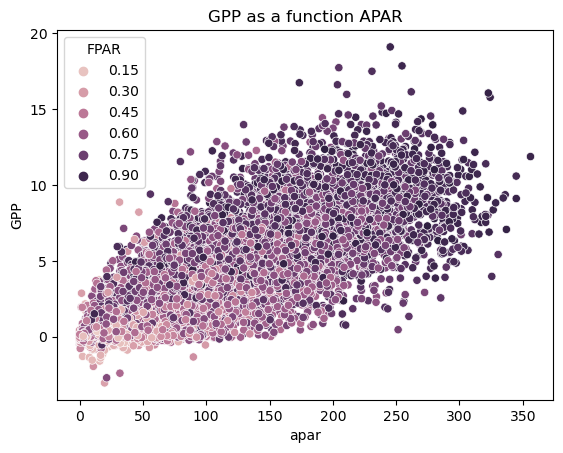

In [30]:
df_clean["apar"] = df_clean["SW_IN_F_MDS"] * df_clean["FPAR"]
sns.scatterplot(x="apar", y="GPP", hue="FPAR", data=df_clean.sample(10000))
plt.title("GPP as a function APAR")
plt.show()

We can now remove any non-environmental feature which we will not use any more:

In [31]:
excluded_features = [
    "CO2_F_MDS",  # As explained above
    "GPP_DT_VUT_REF",  # Already included in GPP
    "GPP_NT_VUT_REF",  # Already included in GPP
    "GPP_diff",
    "TIMESTAMP",
    "sitename",
    "lat",
    "day_of_year",
    "month",
    "year",
]
working_features = [f for f in features(df_clean) if f not in excluded_features]
df_prep = df_clean[working_features].copy()
df_prep.shape

(165328, 23)

Let us plot GPP against all the features we have so far:

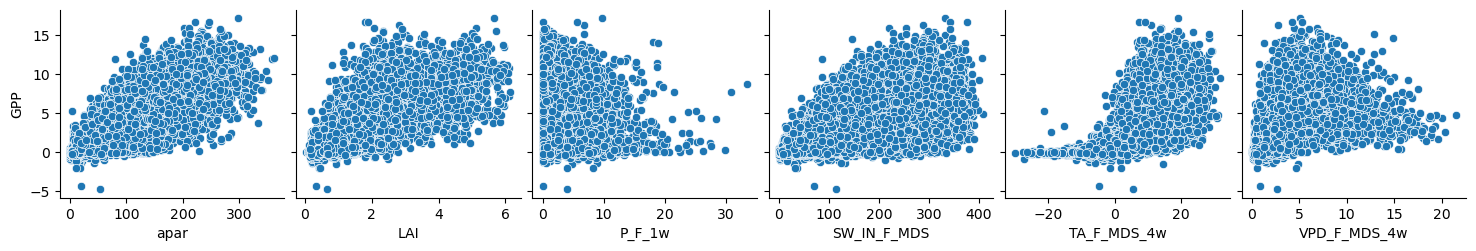

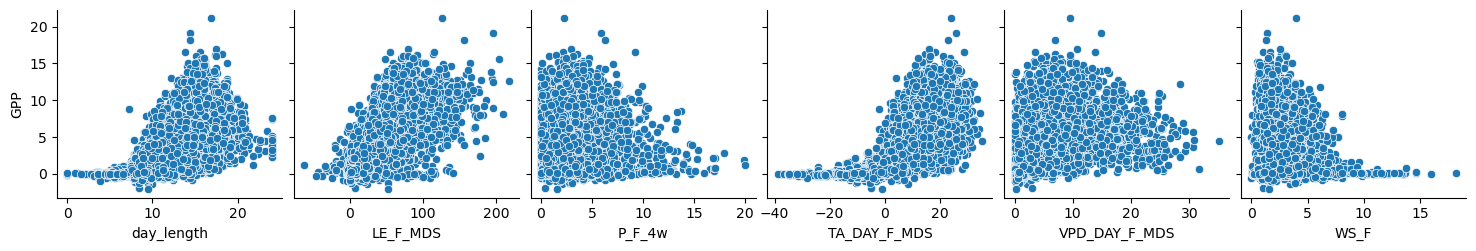

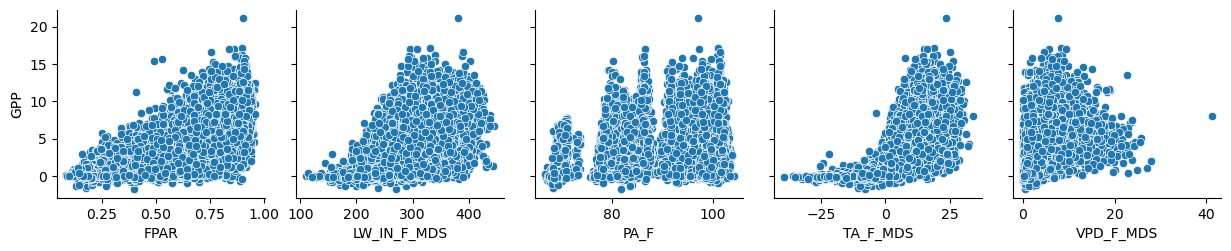

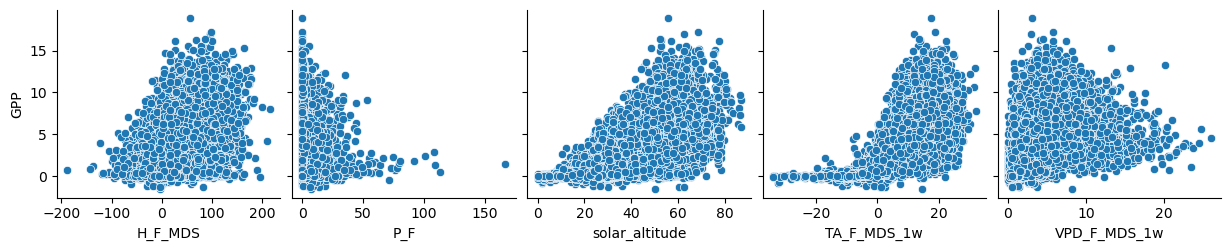

In [32]:
samples = 10000
nrows = 4
feat = [f for f in df_prep.columns.values if f != "GPP"]
feat = sorted(feat, key=str.casefold)
for r in range(0, nrows):
    sns.pairplot(df_prep.sample(samples), x_vars=feat[r::nrows], y_vars=["GPP"])
plt.show()

There are many features which seem to be fairly linear with GPP (which is good news).

We also note that the temperature (`TA_F_MDS` and related) seems to be quadratic with GPP.
We decide therefore to add a features:

In [33]:
df_prep["TA_F_MDS**2"] = (df_prep["TA_F_MDS"] + 41) ** 2
df_prep["TA_F_MDS_1w**2"] = (df_prep["TA_F_MDS_1w"] + 41) ** 2
df_prep["TA_F_MDS_4w**2"] = (df_prep["TA_F_MDS_4w"] + 41) ** 2

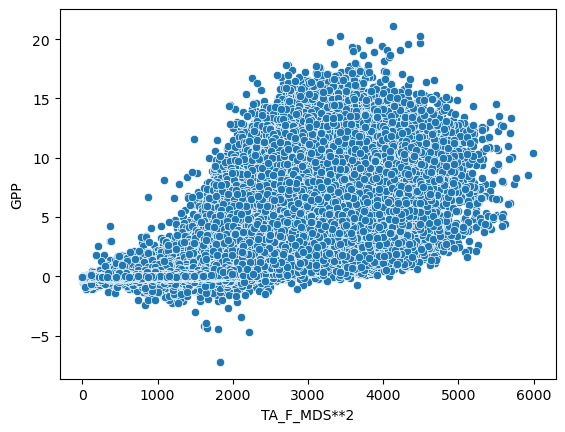

In [34]:
sns.scatterplot(x="TA_F_MDS**2", y="GPP", data=df_prep)
plt.show()

We also decide to get rid of some features which seem redundant:
- `VPD_DAY_F_MDS`: too correlated with `VPD_F_MDS`
- `TA_DAY_F_MDS`: too correlated with `TA_F_MDS`
- `P_F`: since today's precipitation is unlikely to have an effect before tomorrow. We prefer to rely on the previous week average.

In [35]:
df_prep.drop(["VPD_DAY_F_MDS", "TA_DAY_F_MDS", "P_F"], axis=1, inplace=True)
df_prep.shape

(165328, 23)

### Correlation

Let us plot the correlation matrix to get a more precise picture of the correlations:

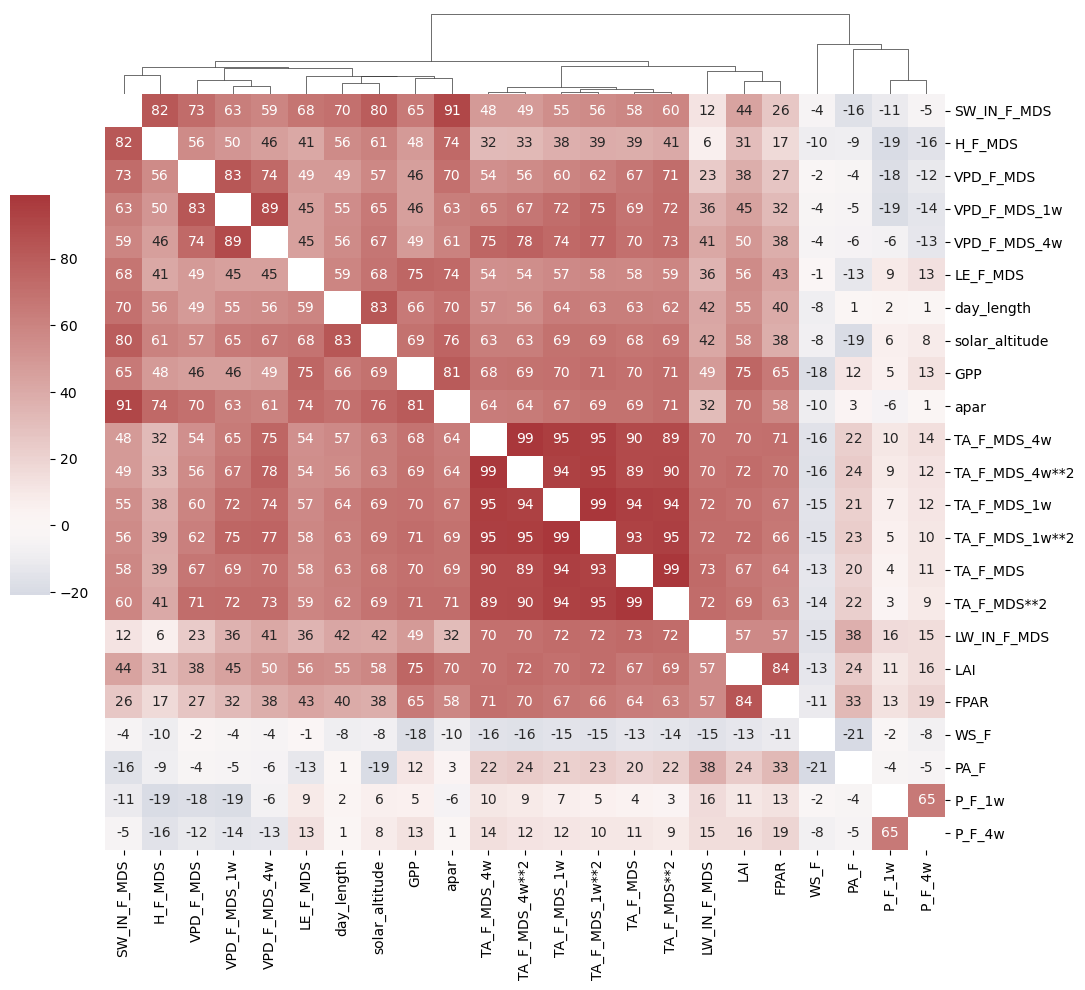

In [36]:
df_corr = df_prep.corr(method="pearson")
sns.clustermap(
    df_corr * 100,
    mask=np.eye(len(df_corr)),
    center=0,
    cmap="vlag",
    cbar_pos=(-0.08, 0.4, 0.04, 0.4),
    dendrogram_ratio=(0, 0.1),
    figsize=(10, 10),
    annot=True,
    fmt=".0f",
)
plt.show()

We find that GPP highly correlates with our engineered feature `apar` which comfort our intuition.
`LAI` and, very interestingly, `LE_F_MDS` also correlate well. `LE_F_MDS` is the latent heat flux and characterizes the amount of evaporation, which could be a proxy to the amount of evapotranspiration?
Other good correlations are temperature, solar elevation and day length.

I would have guessed to see a better correlation with precipitation, especially long term precipitation (`P_F_28d`), but it is not the case.
It looks like water is not a limiting factor for the selected sites (which see plenty of rainfall because of their location).

We also note that a lot of features are very highly correlated with each other.
Regularization will be required to prevent numerical instability.

### Distributions and feature transformations

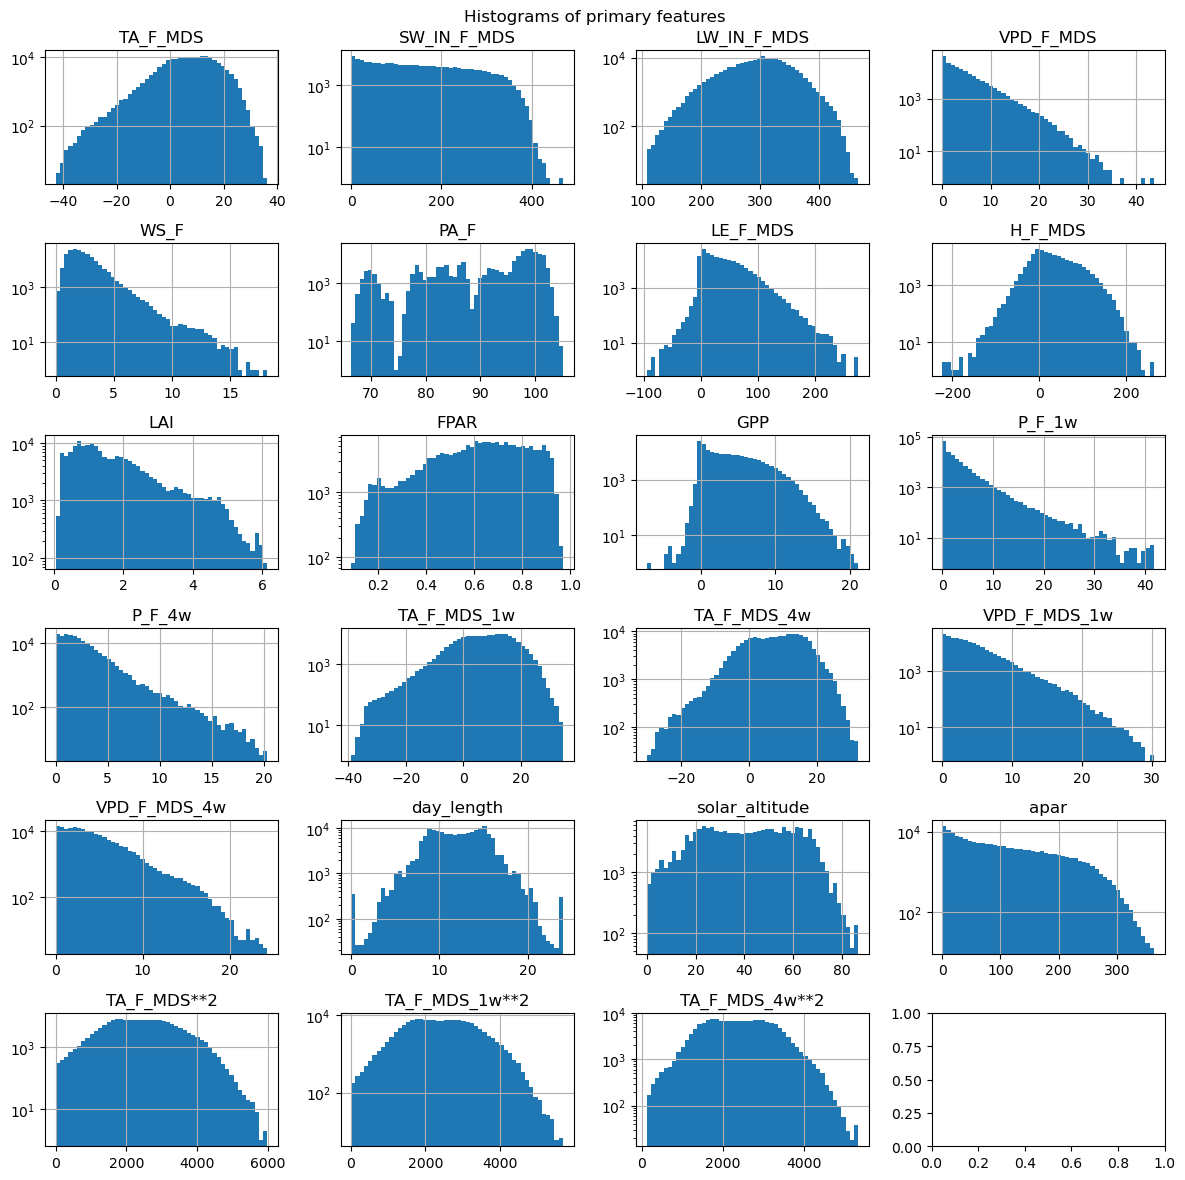

In [37]:
nrows = 6
feats = df_prep.columns.values
ncols = math.ceil(len(feats) / nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
for feat, ax in zip(feats, axes.flatten()):
    df_prep[feat].hist(bins=50, ax=ax, log=True)
    ax.set_title(feat)
plt.suptitle("Histograms of primary features")
plt.tight_layout()
plt.show()

It is clear that the distribution of many features (including `GPP`) is biased and this could lead to some issues with some models such as linear regressions.
A logarithmic transformation did not really help in this case.
The strategy we opt for is to attempt using a quantile transformer on both the target variable and the independent features.
This should be able to center the distributions.

#### Scaling

Scaling is required in most machine learning models.
We will try both the StandardScaler, RobustScaler (using median and interquartile), and, as mentioned above, the QuantileTransformer.

### Outlier handling strategy

Because of our lack of domain knowledge, setting the outlier criteria is difficult and may result in discarding data bearing important information.
We decide to avoid adding an outlier detection and removal stage, and rely instead on both the use of robust scaling and regularization to avoid overfitting issues.

## Test split

We are now ready to create our train/validate and test splits.

Because we had to get rid of many samples, our time series are now sparse, which excludes the possibility to continue working with temporal data.
Therefore, we chose to use a simple shuffle split.
We could use a stratify split to ensure that all the sites are present in the same proportion in both splits, but having disparities is actually interesting for the test estimation.

Note: we will also test the models on the site that we set aside in the first notebook, so we can evaluate the response to the models to a totally unseen site.

In [38]:
tv_split, test_split = train_test_split(df_prep, test_size=0.3, random_state=0)
print(f"Test/validate: {tv_split.shape}")
print(f"Train: {test_split.shape}")

Test/validate: (115729, 23)
Train: (49599, 23)


We make sure that we have roughly all the sites in both sets:

In [39]:
print(
    f"Number of sites (train/validate): {len(tv_split.index.get_level_values(0).unique())}"
)
print(f"Number of sites (test): {len(test_split.index.get_level_values(0).unique())}")

Number of sites (train/validate): 58
Number of sites (test): 58


Finally, we persist to disk.

In [ ]:
tv_split.to_csv(tv_split_path)
test_split.to_csv(test_split_path)